# Part A: Convolutional Neural Network

## Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import pathlib, os, random
from pathlib import Path

## Constants

In [2]:
SEED        = 88
ROOT        = pathlib.Path("Dataset for CA1 part A - AY2526S1")  # <-- adjust path if needed
IMG_SIZE    = (224, 224)    # load at original size first
BATCH_SIZE  = 256
LABEL_MODE  = "categorical" # one‑hot labels straight away

## Data Preprocessing

In [3]:
def load_split(split):
    return tf.keras.preprocessing.image_dataset_from_directory(
        ROOT / split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)

train_ds = load_split("train")
val_ds   = load_split("validation")
test_ds  = load_split("test")

class_names = train_ds.class_names       # e.g. ['Bean', 'Bitter_Gourd', …]
print("Detected classes:", class_names)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Detected classes: ['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']


## Renaming of files

In [4]:
# -------------------------------------------------------------
#  Tidy class‑folder names once, then reload your datasets
# -------------------------------------------------------------
from pathlib import Path
import re, shutil

ROOT   = Path("Dataset for CA1 part A - AY2526S1")   # edit if needed
SPLITS = ["train", "validation", "test"]

# 1️⃣  generic clean‑up rules
def tidy(name: str) -> str:
    name = name.replace(" with ", " and ")               # with → and
    name = re.sub(r"\s*\(.*?\)\s*", " ", name)           # drop (…) notes
    return " ".join(name.split())                        # trim & squeeze

# 2️⃣  specific “flip” corrections *after* the generic rules
FLIP_MAP = {
    "Bottle_Gourd and Cucumber": "Cucumber and Bottle_Gourd",
    "Broccoli and Cauliflower":  "Cauliflower and Broccoli",
    "Carrot and Radish":         "Radish and Carrot",
}

for split in SPLITS:
    for folder in (ROOT / split).iterdir():
        if not folder.is_dir():
            continue
        new_name = tidy(folder.name)                 # generic tidy first
        new_name = FLIP_MAP.get(new_name, new_name)  # then flip if needed
        if new_name == folder.name:
            continue                                 # already neat
        dst = folder.parent / new_name
        if dst.exists():
            # merge: move files, then delete empty source
            for img in folder.iterdir():
                shutil.move(str(img), dst / img.name)
            folder.rmdir()
            action = "merged"
        else:
            folder.rename(dst)
            action = "renamed"
        print(f"{action:<6}  {split}/{folder.name}  →  {split}/{new_name}")

# -------------------------------------------------------------
#  Quick sanity check – all splits should list the same 11 names
# -------------------------------------------------------------
def list_dirs(split):
    return sorted([p.name for p in (ROOT / split).iterdir() if p.is_dir()])

for sp in SPLITS:
    print(f"{sp:<11}", list_dirs(sp))


train       ['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']
validation  ['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']
test        ['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']


# EDA

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Build unified class list & reload datasets (ensures tidy folders)
# ─────────────────────────────────────────────────────────────────────────────
CANON_CLASSES = class_names  # from your load_split call

def load_split(split):
    return tf.keras.preprocessing.image_dataset_from_directory(
        ROOT / split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE,
        class_names = CANON_CLASSES)

train_ds = load_split("train")
val_ds   = load_split("validation")
test_ds  = load_split("test")

print("✅ Classes:", CANON_CLASSES)


Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
✅ Classes: ['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']


,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
train,784,720,868,503,351,948,875,377,814,504,955
validation,200,200,200,200,200,200,200,200,200,200,200
test,200,200,200,200,200,200,200,200,200,200,200


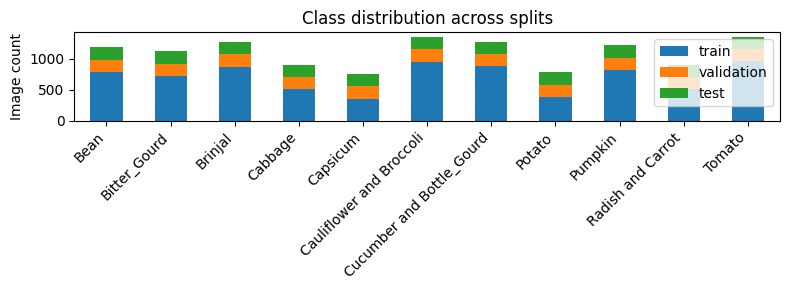

In [6]:

def count_images(split):
    return {cls: len(list((ROOT/split/cls).iterdir()))
            for cls in CANON_CLASSES}

df_counts = pd.DataFrame({s: count_images(s) for s in SPLITS}).T
display(df_counts)  # nice Jupyter table

# stacked bar chart
ax = df_counts.T.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


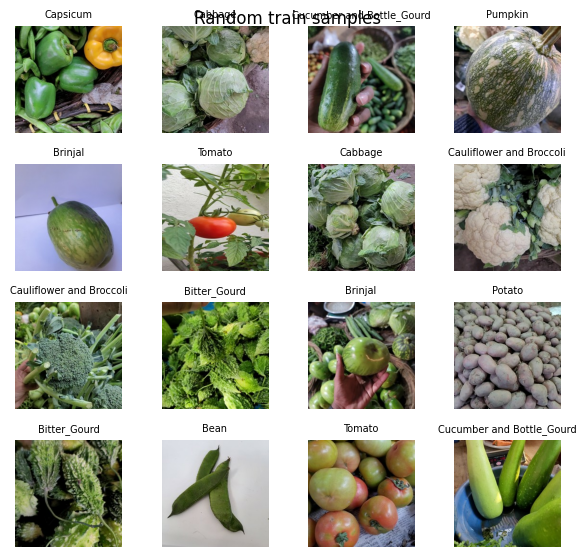

In [7]:

plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CANON_CLASSES[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()


In [8]:

def approx_mean_std(ds, batches=50):
    n_px, s1, s2 = 0, np.zeros(3), np.zeros(3)
    for imgs, _ in ds.take(batches):
        arr = imgs.numpy() / 255.0
        n = arr.shape[0] * arr.shape[1] * arr.shape[2]
        n_px += n
        s1   += arr.sum(axis=(0,1,2))
        s2   += (arr**2).sum(axis=(0,1,2))
    mean = s1 / n_px
    std  = np.sqrt(s2/n_px - mean**2)
    return mean, std

mean, std = approx_mean_std(train_ds)
print("Channel means :", np.round(mean,4))
print("Channel stds  :", np.round(std,4))


Channel means : [0.4572 0.4616 0.3446]
Channel stds  : [0.2359 0.2319 0.2407]


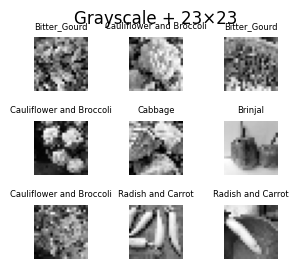

In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# grayscale + resize preview (23×23)
# ─────────────────────────────────────────────────────────────────────────────
TARGET = 23
sample = (
    train_ds
      .map(lambda x,y: (tf.image.resize(tf.image.rgb_to_grayscale(x), [TARGET,TARGET]) / 255.0, y))
      .unbatch()
      .take(9)
)

plt.figure(figsize=(3,3))
for i, (img, lbl) in enumerate(sample):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img.numpy().squeeze(), cmap="gray")
    plt.title(CANON_CLASSES[np.argmax(lbl)], fontsize=6)
    plt.axis("off")
plt.suptitle(f"Grayscale + {TARGET}×{TARGET}", y=0.88)
plt.tight_layout()
plt.show()


# Data Preprocessing

In [10]:
CANON_CLASSES = sorted([p.name for p in (ROOT/"train").iterdir() if p.is_dir()])
NUM_CLASSES   = len(CANON_CLASSES)
TARGET_SIZES  = {               # the two resolutions you must experiment with
    "small":  23,
    "medium": 101
}
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers, Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras_tuner import RandomSearch

# Early stopping / checkpoint / LR reduction
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)

lr_reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

ckpt23 = callbacks.ModelCheckpoint(
    "best_23x23.h5", monitor="val_loss", save_best_only=True)

ckpt101 = callbacks.ModelCheckpoint(
    "best_101x101.h5", monitor="val_loss", save_best_only=True)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

AUTOTUNE   = tf.data.AUTOTUNE
IMG_SIZE   = (224,224)  # load at original size first
BATCH_SIZE = 32
LABEL_MODE = "categorical"
SEED       = 88

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def make_ds(split, target_size, augment=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ROOT/split,
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode=LABEL_MODE,
        class_names=CANON_CLASSES
    )
    def _prep(img, lbl):
        img = tf.image.rgb_to_grayscale(img)
        img = tf.image.resize(img, [target_size, target_size])
        img = img / 255.0
        if augment:
            img = data_augmentation(img)
        return img, lbl

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

# ─────────────────────────────────────────────────────────────────────────────
# Model A: small capacity for 23×23 grayscale inputs
# ─────────────────────────────────────────────────────────────────────────────
def build_baseline_23(input_size=TARGET_SIZES["small"], num_classes=NUM_CLASSES):
    model = Sequential(name="baseline_23x23")
    
    # Conv block 1
    model.add(layers.InputLayer(input_shape=(input_size, input_size, 1)))
    model.add(layers.Conv2D(32, (5,5), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))    
    # Conv block 2
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))

    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))
    
    # Classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(11, activation="softmax"))
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [104]:
ds23_train = make_ds("train", TARGET_SIZES["small"], augment=False)
ds23_val   = make_ds("validation", TARGET_SIZES["small"], augment=False)
ds23_test  = make_ds("test", TARGET_SIZES["small"], augment=False)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [112]:
model23_do = build_baseline_23(TARGET_SIZES["small"])
history23_do = model23_do.fit(
    ds23_train,
    validation_data=ds23_val,
    epochs=50,
    callbacks=[early_stop, ckpt23, lr_reduce],
    verbose=1
)

loss23_do, acc23_do = model23_do.evaluate(ds23_test, verbose=0)
print(f"📈 23×23 w/ Dropout test accuracy: {acc23_do:.2%}")

Epoch 1/50
241/241 [==============================] - 4s 6ms/step - loss: 2.3076 - accuracy: 0.1394 - val_loss: 2.2696 - val_accuracy: 0.1245 - lr: 0.0010
Epoch 2/50
241/241 [==============================] - 3s 6ms/step - loss: 2.1399 - accuracy: 0.2363 - val_loss: 2.1465 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 3/50
241/241 [==============================] - 3s 6ms/step - loss: 1.9461 - accuracy: 0.3256 - val_loss: 1.7807 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 4/50
241/241 [==============================] - 3s 6ms/step - loss: 1.7356 - accuracy: 0.4069 - val_loss: 1.7062 - val_accuracy: 0.4482 - lr: 0.0010
Epoch 5/50
241/241 [==============================] - 3s 6ms/step - loss: 1.5837 - accuracy: 0.4685 - val_loss: 1.4512 - val_accuracy: 0.5318 - lr: 0.0010
Epoch 6/50
241/241 [==============================] - 3s 6ms/step - loss: 1.4458 - accuracy: 0.5119 - val_loss: 1.2390 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 7/50
241/241 [==============================] - 3s 6ms/step - lo

In [145]:
import itertools
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

# ─────────────────────────────────────────────────────────────────────────────
# 1) Builder with exactly 4 Conv2D blocks, tunable head_units, lr & conv_dropout
# ─────────────────────────────────────────────────────────────────────────────
def build_baseline_101_tuned(
    input_size=TARGET_SIZES["medium"],
    num_classes=NUM_CLASSES,
    conv_drop=0.3,
    head_units=256,
    lr=1e-4
):
    model = Sequential(name=f"bs101_cd{conv_drop}_hu{head_units}_lr{lr}")
    model.add(layers.InputLayer(input_shape=(input_size, input_size, 1)))

    # ── 4 Conv2D blocks ───────────────────────────────────────
    # Block 1
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 101→50
    model.add(layers.Dropout(conv_drop))

    # Block 2
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 50→25
    model.add(layers.Dropout(conv_drop))

    # Block 3
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 25→12
    model.add(layers.Dropout(conv_drop))

    # Block 4
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 12→6
    model.add(layers.Dropout(conv_drop))

    # ── Global pooling + tunable head + output ───────────────
    model.add(layers.GlobalAveragePooling2D())             # 6×6×256 → 256
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(head_units, activation="relu")) # <— tunable
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ─────────────────────────────────────────────────────────────────────────────
# 2) Hyperparameter grids
# ─────────────────────────────────────────────────────────────────────────────
head_units_grid = [128, 256, 512]   # second-last Dense layer size
lr_grid         = [1e-3, 1e-4]      # learning rates to try
batch_grid      = [32, 64]          # batch sizes
dropout_grid    = [0.25, 0.35]      # conv-block dropout rates

# ─────────────────────────────────────────────────────────────────────────────
# 3) Callbacks & base datasets
# ─────────────────────────────────────────────────────────────────────────────
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
temp_ckpt = "temp_best.h5"
best_ckpt = "best_101_weights.h5"

ds_train_base = make_ds("train", TARGET_SIZES["medium"], augment=True).unbatch()
ds_val_base   = make_ds("validation", TARGET_SIZES["medium"], augment=False).unbatch()

# ─────────────────────────────────────────────────────────────────────────────
# 4) Grid search
# ─────────────────────────────────────────────────────────────────────────────
best_overall = {"val_acc": 0.0}
results = []

for head_units, lr, batch_size, conv_drop in itertools.product(
    head_units_grid, lr_grid, batch_grid, dropout_grid
):
    print(f"\n>>> Testing head={head_units}, lr={lr}, bs={batch_size}, drop={conv_drop}")
    model = build_baseline_101_tuned(
        conv_drop=conv_drop,
        head_units=head_units,
        lr=lr
    )

    # checkpoint to capture best epoch of this run
    ckpt = ModelCheckpoint(
        temp_ckpt,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=0
    )

    # re-batch
    ds_train = ds_train_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # train with one-line/epoch logs
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=20,
        callbacks=[early_stop, ckpt],
        verbose=2
    )

    # load best-epoch weights, evaluate
    model.load_weights(temp_ckpt)
    _, val_acc = model.evaluate(ds_val, verbose=0)

    results.append({
        "head_units": head_units,
        "learning_rate": lr,
        "batch_size": batch_size,
        "conv_dropout": conv_drop,
        "val_accuracy": val_acc
    })

    # save best overall
    if val_acc > best_overall["val_acc"]:
        best_overall = results[-1].copy()
        model.save_weights(best_ckpt)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Report top configs & best
# ─────────────────────────────────────────────────────────────────────────────
results.sort(key=lambda x: x["val_accuracy"], reverse=True)
print("\nTop 5 configurations:")
for r in results[:5]:
    print(r)

print("\nBest overall:")
print(best_overall)
print(f"Best weights saved to: {best_ckpt}")


Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Epoch 1/50
241/241 [==============================] - 11s 35ms/step - loss: 2.3199 - accuracy: 0.1233 - val_loss: 2.2880 - val_accuracy: 0.1227 - lr: 1.0000e-04
Epoch 2/50
241/241 [==============================] - 10s 35ms/step - loss: 2.0972 - accuracy: 0.2083 - val_loss: 2.0178 - val_accuracy: 0.2445 - lr: 1.0000e-04
Epoch 3/50
241/241 [==============================] - 10s 35ms/step - loss: 1.9603 - accuracy: 0.2700 - val_loss: 1.9649 - val_accuracy: 0.2686 - lr: 1.0000e-04
Epoch 4/50
241/241 [==============================] - 10s 35ms/step - loss: 1.8503 - accuracy: 0.3051 - val_loss: 2.0114 - val_accuracy: 0.2514 - lr: 1.0000e-04
Epoch 5/50
241/241 [==============================] - 10s 35ms/step - loss: 1.7219 - accuracy: 0.3665 - val_loss: 1.8149 - val_accuracy: 0.3568 - lr: 1.0000e-04
Epoch 6/50
241/241 [==============================] - 10s 35ms/step -

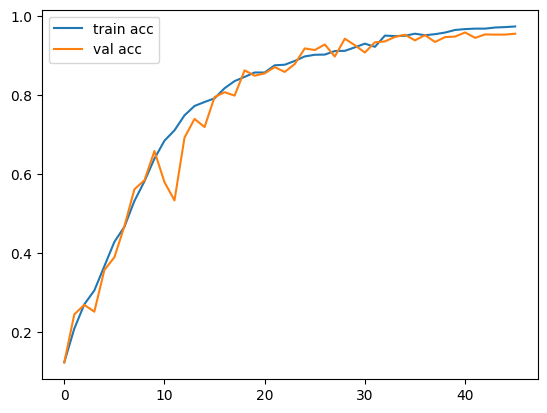

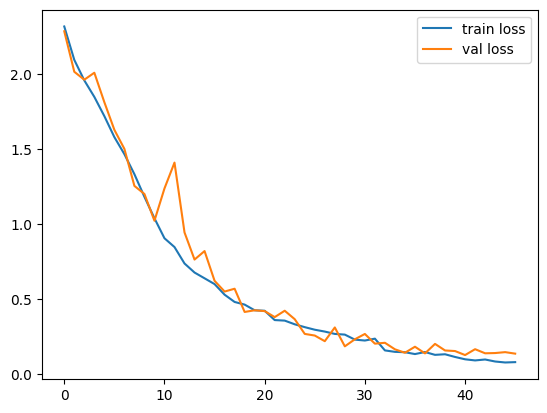

In [146]:
plt.plot(history101_slim.history['accuracy'], label='train acc')
plt.plot(history101_slim.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()

plt.plot(history101_slim.history['loss'], label='train loss')
plt.plot(history101_slim.history['val_loss'], label='val loss')
plt.legend(); plt.show()

## Hyperparameter Tuning

### Model Builder

In [21]:
# %% Cell 1: Imports & Hyperparameter Setup
import itertools
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

# Hyperparameter grids
head_units_grid = [128, 256, 512]   # size of the dense layer below GAP
lr_grid         = [1e-3, 1e-4, 1e-5]      # learning rates to try
batch_grid      = [64, 128, 256]          # batch sizes
dropout_grid    = [0.25, 0.35, 0.45]      # dropout rates for conv blocks

# Paths for checkpointing
temp_ckpt = "temp_best.h5"
best_ckpt = "best_101_weights.h5"


In [22]:
# %% Cell 2: Model Builder (4 Conv Blocks + Tunable Head)
def build_baseline_101_tuned(
    input_size=TARGET_SIZES["medium"],
    num_classes=NUM_CLASSES,
    conv_drop=0.3,
    head_units=256,
    lr=1e-4
):
    model = Sequential(name=f"bs101_cd{conv_drop}_hu{head_units}_lr{lr}")
    model.add(layers.InputLayer(input_shape=(input_size, input_size, 1)))

    # ── Block 1 ───────────────────────────────────────
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 101→50
    model.add(layers.Dropout(conv_drop))

    # ── Block 2 ───────────────────────────────────────
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 50→25
    model.add(layers.Dropout(conv_drop))

    # ── Block 3 ───────────────────────────────────────
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 25→12
    model.add(layers.Dropout(conv_drop))

    # ── Block 4 ───────────────────────────────────────
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 12→6
    model.add(layers.Dropout(conv_drop))

    # ── Global pooling + Tunable Head + Output ───────
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(head_units, activation="relu"))  # tunable
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [23]:
# EarlyStopping & temp checkpoint saver
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

# Load & unbatch datasets once
ds_train_base = make_ds("train", TARGET_SIZES["medium"], augment=False).unbatch()
ds_val_base   = make_ds("validation", TARGET_SIZES["medium"], augment=False).unbatch()


Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [ ]:
# %% Cell 4: Grid Search Loop (print every 5 epochs + final if early-stopped)
best_overall = {"val_accuracy": 0.0}
results = []

class PrintEveryN(callbacks.Callback):
    def __init__(self, n):
        super().__init__()
        self.n = n
    def on_epoch_end(self, epoch, logs=None):
        # epoch is zero-indexed
        if (epoch + 1) % self.n == 0:
            logs = logs or {}
            print(
                f"  → Epoch {epoch+1:2d}: "
                f"loss={logs.get('loss',0):.4f}, "
                f"acc={logs.get('accuracy',0):.4f}, "
                f"val_loss={logs.get('val_loss',0):.4f}, "
                f"val_acc={logs.get('val_accuracy',0):.4f}"
            )
    def on_train_end(self, logs=None):
        # nothing here – we'll handle final print manually below
        pass

PRINT_N = 5

for head_units, lr, batch_size, conv_drop in itertools.product(
    head_units_grid, lr_grid, batch_grid, dropout_grid
):
    print(f"\n>>> Testing head={head_units}, lr={lr}, bs={batch_size}, drop={conv_drop}")
    model = build_baseline_101_tuned(
        conv_drop=conv_drop,
        head_units=head_units,
        lr=lr
    )

    ckpt = ModelCheckpoint(
        temp_ckpt,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=0
    )
    print_every = PrintEveryN(PRINT_N)

    ds_train = ds_train_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=15,
        callbacks=[early_stop, ckpt, print_every],
        verbose=0
    )

    # If the run stopped before hitting epoch multiples of PRINT_N,
    # we need to print the final epoch metrics:
    total_epochs = len(history.history['loss'])
    if total_epochs % PRINT_N != 0:
        # grab the last epoch's logs
        last_logs = {
            'loss':         history.history['loss'][-1],
            'accuracy':     history.history['accuracy'][-1],
            'val_loss':     history.history['val_loss'][-1],
            'val_accuracy': history.history['val_accuracy'][-1]
        }
        print(
            f"  → Epoch {total_epochs:2d} (final): "
            f"loss={last_logs['loss']:.4f}, "
            f"acc={last_logs['accuracy']:.4f}, "
            f"val_loss={last_logs['val_loss']:.4f}, "
            f"val_acc={last_logs['val_accuracy']:.4f}"
        )

    # Evaluate the best epoch for this run
    model.load_weights(temp_ckpt)
    val_loss, val_acc = model.evaluate(ds_val, verbose=0)

    results.append({
        "head_units":    head_units,
        "learning_rate": lr,
        "batch_size":    batch_size,
        "conv_dropout":  conv_drop,
        "val_accuracy":  val_acc
    })

    if val_acc > best_overall["val_accuracy"]:
        best_overall = results[-1].copy()
        model.save_weights(best_ckpt)



>>> Testing head=128, lr=0.001, bs=64, drop=0.25
  → Epoch  5: loss=1.9384, acc=0.3185, val_loss=1.8013, val_acc=0.3823
  → Epoch 10: loss=1.1006, acc=0.6437, val_loss=0.9669, val_acc=0.6982
  → Epoch 15: loss=0.5114, acc=0.8354, val_loss=0.5017, val_acc=0.8386

>>> Testing head=128, lr=0.001, bs=64, drop=0.35
  → Epoch  4 (final): loss=2.3504, acc=0.1243, val_loss=2.4523, val_acc=0.0909

>>> Testing head=128, lr=0.001, bs=64, drop=0.45
  → Epoch  5: loss=1.9943, acc=0.2431, val_loss=1.9007, val_acc=0.3141
  → Epoch 10: loss=1.4608, acc=0.4575, val_loss=1.4715, val_acc=0.4559
  → Epoch 15: loss=1.0536, acc=0.6168, val_loss=0.8864, val_acc=0.6859

>>> Testing head=128, lr=0.001, bs=128, drop=0.25
  → Epoch  5: loss=1.8527, acc=0.3224, val_loss=1.7809, val_acc=0.3495
  → Epoch 10: loss=1.1560, acc=0.5886, val_loss=1.0211, val_acc=0.6186
  → Epoch 15: loss=0.6739, acc=0.7740, val_loss=0.6933, val_acc=0.7573

>>> Testing head=128, lr=0.001, bs=128, drop=0.35
  → Epoch  5: loss=2.1929, acc

In [56]:
best_mid101 = tuner_mid101.hypermodel.build(best_hps)
best_mid101.compile(
    optimizer=optimizers.Adam(learning_rate=best_hps.get("lr")),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [59]:
# 6) (Optional) Fine-tune with EarlyStopping + Checkpoint
history_best_mid101 = best_mid101.fit(
    ds101_train,
    validation_data=ds101_val,
    epochs=50,
    callbacks=[early_stop, lr_reduce, ckpt101],
    verbose=1
)

# 7) Final evaluation
loss_best, acc_best = best_mid101.evaluate(ds101_test, verbose=0)
print(f"✅ Tuned mid 101×101 test accuracy: {acc_best:.2%}")

Epoch 1/50
31/31 [==============================] - 6s 107ms/step - loss: 0.0403 - accuracy: 0.9912 - val_loss: 0.8197 - val_accuracy: 0.8123 - lr: 1.1191e-06
Epoch 2/50
31/31 [==============================] - 6s 108ms/step - loss: 0.0410 - accuracy: 0.9908 - val_loss: 0.8203 - val_accuracy: 0.8123 - lr: 1.1191e-06
Epoch 3/50
31/31 [==============================] - 6s 110ms/step - loss: 0.0392 - accuracy: 0.9919 - val_loss: 0.8204 - val_accuracy: 0.8123 - lr: 1.1191e-06
Epoch 4/50
31/31 [==============================] - 6s 110ms/step - loss: 0.0440 - accuracy: 0.9903 - val_loss: 0.8202 - val_accuracy: 0.8123 - lr: 1.1191e-06
Epoch 5/50
31/31 [==============================] - 6s 108ms/step - loss: 0.0430 - accuracy: 0.9909 - val_loss: 0.8197 - val_accuracy: 0.8123 - lr: 1.0000e-06
Epoch 6/50
31/31 [==============================] - 6s 114ms/step - loss: 0.0430 - accuracy: 0.9904 - val_loss: 0.8193 - val_accuracy: 0.8123 - lr: 1.0000e-06
Epoch 7/50
31/31 [============================

## Checking which hyperparameters i should tune

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) pull out each trial’s hyperparameters + score
trials = list(tuner_mid101.oracle.trials.values())   # all the trials you just ran
records = []
for t in trials:
    hp = t.hyperparameters.values.copy()
    hp["score"] = t.score
    records.append(hp)

df = pd.DataFrame(records)
df

,conv1_filters,conv2_filters,dense_units,dropout_rate,lr,score
0,32,96,192,0.3,0.002292,0.805455
1,32,64,64,0.5,0.000245,0.465909
2,48,32,128,0.4,0.000415,0.698182
3,16,64,128,0.1,0.003318,0.723182
4,32,128,192,0.4,0.000228,0.719545
5,64,64,128,0.2,0.000131,0.640455
6,16,32,256,0.4,0.009929,0.660909
7,16,64,256,0.1,0.000105,0.630455
8,32,128,64,0.1,0.000401,0.683182
9,32,64,64,0.1,0.001337,0.714545


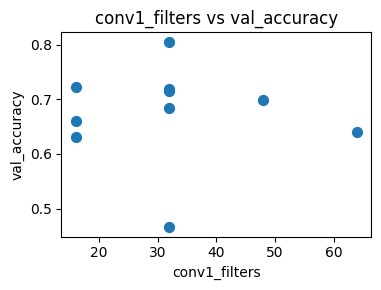

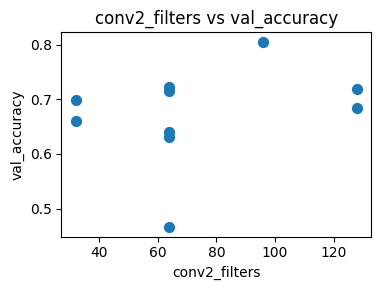

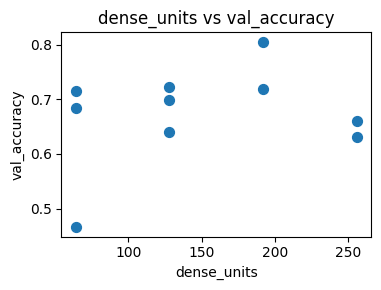

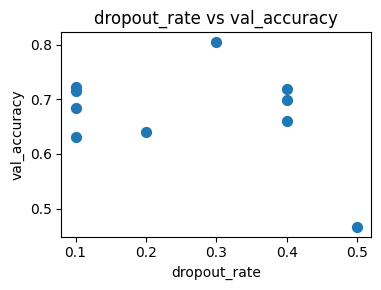

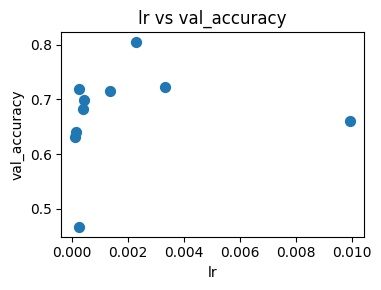

In [64]:
for col in ["conv1_filters","conv2_filters","dense_units","dropout_rate","lr"]:
    plt.figure(figsize=(4,3))
    plt.scatter(df[col], df["score"], s=50)
    plt.title(f"{col} vs val_accuracy")
    plt.xlabel(col)
    plt.ylabel("val_accuracy")
    plt.tight_layout()
    plt.show()

In [65]:
corrs = df.corr()["score"].drop("score").sort_values(ascending=False)
print("Hyperparam correlations with val_accuracy:\n", corrs)

Hyperparam correlations with val_accuracy:
 conv2_filters    0.271549
dense_units      0.239732
lr               0.144165
conv1_filters   -0.047183
dropout_rate    -0.346752
Name: score, dtype: float64


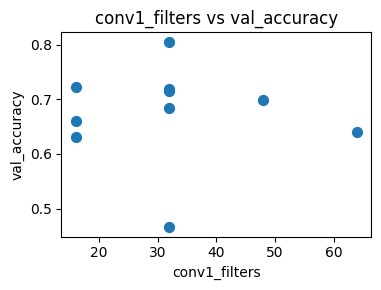

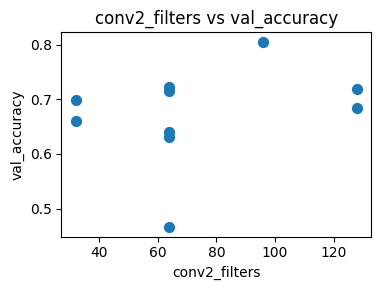

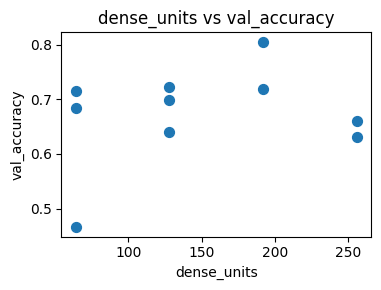

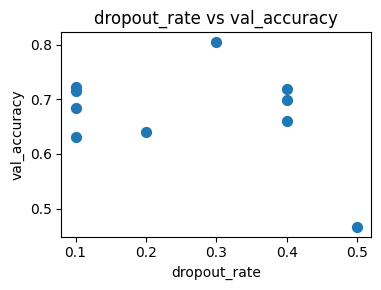

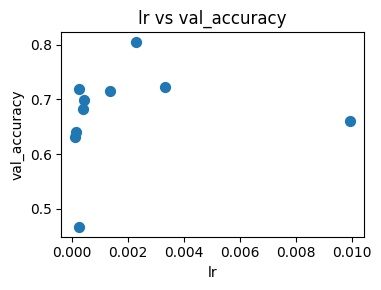

In [66]:
for col in ["conv1_filters","conv2_filters","dense_units","dropout_rate","lr"]:
    plt.figure(figsize=(4,3))
    plt.scatter(df[col], df["score"], s=50)
    plt.title(f"{col} vs val_accuracy")
    plt.xlabel(col)
    plt.ylabel("val_accuracy")
    plt.tight_layout()
    plt.show()


## Post Evaluation Hyperparams tuning

In [67]:
def build_mid_refined(hp):
    """
    Same 2‐conv → Dense→Dropout “mid” model,
    but conv1 fixed and tighter ranges for the others.
    """
    in_sz = TARGET_SIZES["medium"]   # 101
    nc   = NUM_CLASSES

    # fix the first‐layer filters:
    conv1 = 32  
    # sweep conv2 more finely around 96
    conv2 = hp.Int("conv2_filters", 64, 128, step=16)
    # sweep dense head around 192
    dense_units = hp.Int("dense_units", 128, 256, step=64)
    # keep dropout lower
    dropout_rate = hp.Float("dropout_rate", 0.1, 0.4, step=0.1)
    # narrow LR around the ~2e-3 sweet spot
    lr = hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")

    model = Sequential(name="mid_refined_101")
    model.add(layers.Input((in_sz, in_sz, 1)))
    model.add(layers.Conv2D(conv1, 3, padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(conv2, 3, padding="same", activation="relu"))
    model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(nc, activation="softmax"))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [68]:
# Instantiate refined tuner
tuner_refined = RandomSearch(
    build_mid_refined,
    objective="val_accuracy",
    max_trials=8,
    directory="tuner_logs",
    project_name="mid_refined_101_hpt"
)

# Search
tuner_refined.search(
    ds101_train,
    validation_data=ds101_val,
    epochs=20,
    verbose=1
)

Trial 8 Complete [00h 02m 22s]
val_accuracy: 0.7936363816261292

Best val_accuracy So Far: 0.8045454621315002
Total elapsed time: 00h 18m 39s


In [69]:
tuner_refined.results_summary()

Results summary
Results in tuner_logs\mid_refined_101_hpt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
conv2_filters: 80
dense_units: 256
dropout_rate: 0.2
learning_rate: 0.0017942055035993026
Score: 0.8045454621315002

Trial 4 summary
Hyperparameters:
conv2_filters: 64
dense_units: 192
dropout_rate: 0.2
learning_rate: 0.001064610034094168
Score: 0.796818196773529

Trial 6 summary
Hyperparameters:
conv2_filters: 80
dense_units: 192
dropout_rate: 0.4
learning_rate: 0.0037479068447182373
Score: 0.7936363816261292

Trial 7 summary
Hyperparameters:
conv2_filters: 112
dense_units: 256
dropout_rate: 0.1
learning_rate: 0.0024710347797714653
Score: 0.7936363816261292

Trial 0 summary
Hyperparameters:
conv2_filters: 112
dense_units: 128
dropout_rate: 0.2
learning_rate: 0.00047510044010335036
Score: 0.778181791305542

Trial 3 summary
Hyperparameters:
conv2_filters: 112
dense_units: 128
dropout_rate: 0.1
learning_rate: 0.0003630729021021